Train shape: (243787, 21)
Test shape: (104480, 20)

Data Description:
                 Column_name Column_type Data_type  \
0                 AccountAge     Feature   integer   
1             MonthlyCharges     Feature     float   
2               TotalCharges     Feature     float   
3           SubscriptionType     Feature    object   
4              PaymentMethod     Feature    string   
5           PaperlessBilling     Feature    string   
6                ContentType     Feature    string   
7          MultiDeviceAccess     Feature    string   
8           DeviceRegistered     Feature    string   
9        ViewingHoursPerWeek     Feature     float   
10    AverageViewingDuration     Feature     float   
11  ContentDownloadsPerMonth     Feature   integer   
12           GenrePreference     Feature    string   
13                UserRating     Feature     float   
14    SupportTicketsPerMonth     Feature   integer   
15                    Gender     Feature    string   
16          

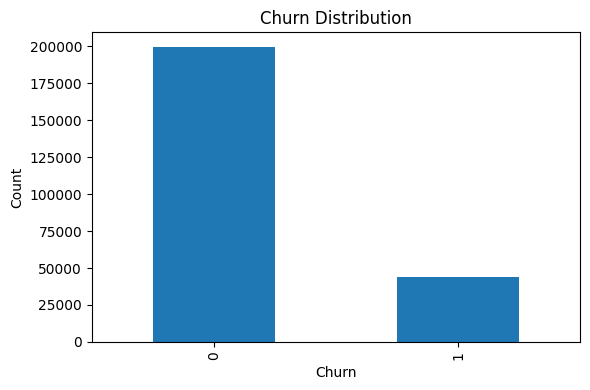

Train shape: (243787, 21)
Test shape: (104480, 20)

Data Description:
                 Column_name Column_type Data_type  \
0                 AccountAge     Feature   integer   
1             MonthlyCharges     Feature     float   
2               TotalCharges     Feature     float   
3           SubscriptionType     Feature    object   
4              PaymentMethod     Feature    string   
5           PaperlessBilling     Feature    string   
6                ContentType     Feature    string   
7          MultiDeviceAccess     Feature    string   
8           DeviceRegistered     Feature    string   
9        ViewingHoursPerWeek     Feature     float   
10    AverageViewingDuration     Feature     float   
11  ContentDownloadsPerMonth     Feature   integer   
12           GenrePreference     Feature    string   
13                UserRating     Feature     float   
14    SupportTicketsPerMonth     Feature   integer   
15                    Gender     Feature    string   
16          

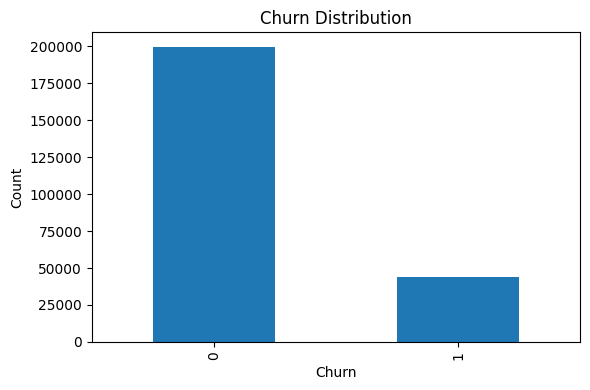

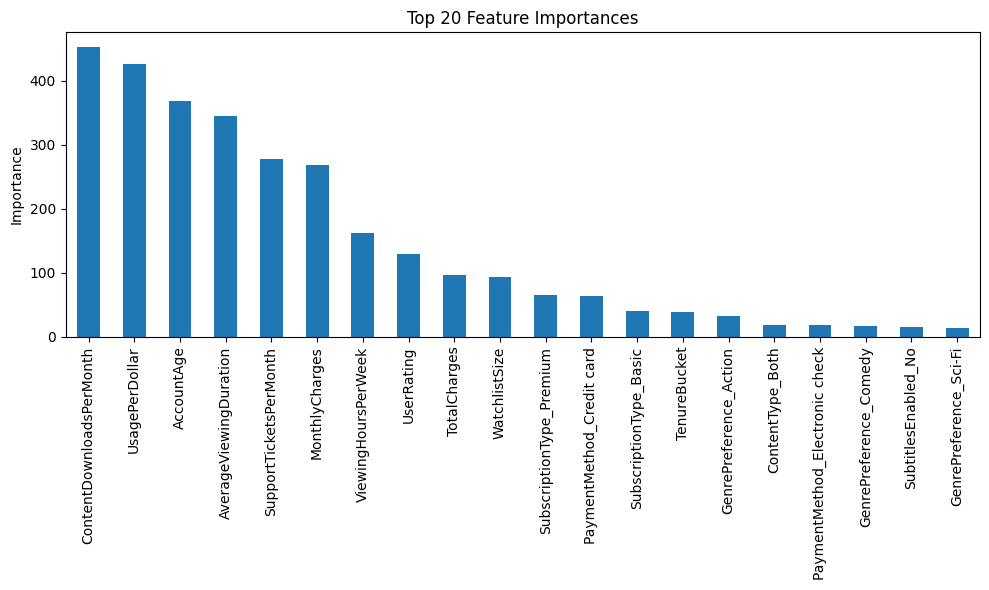

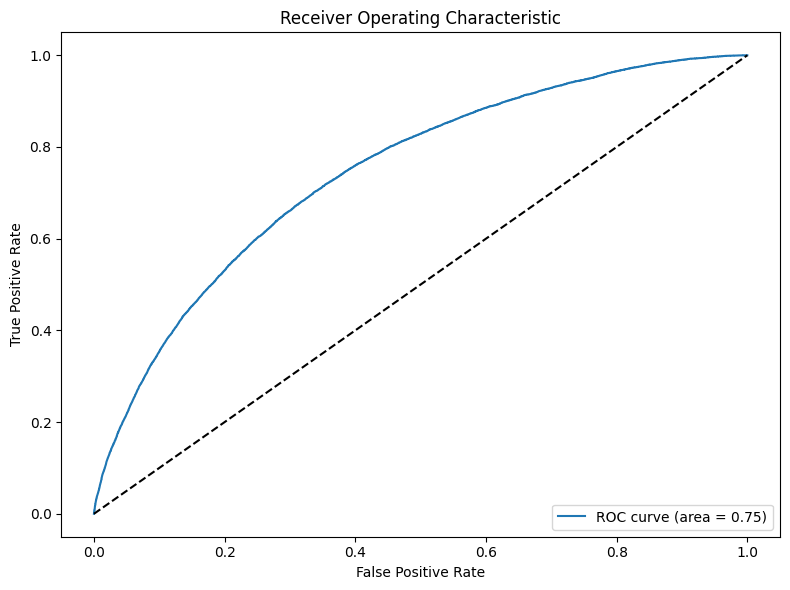

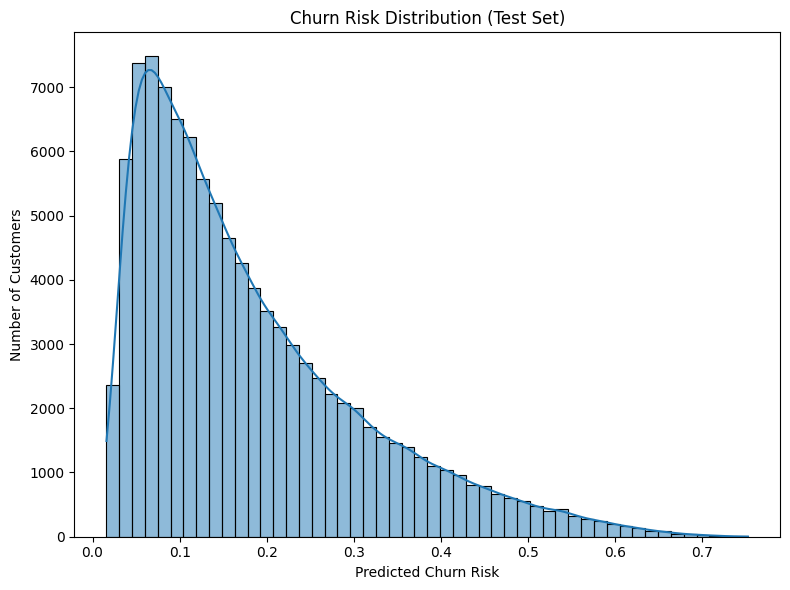

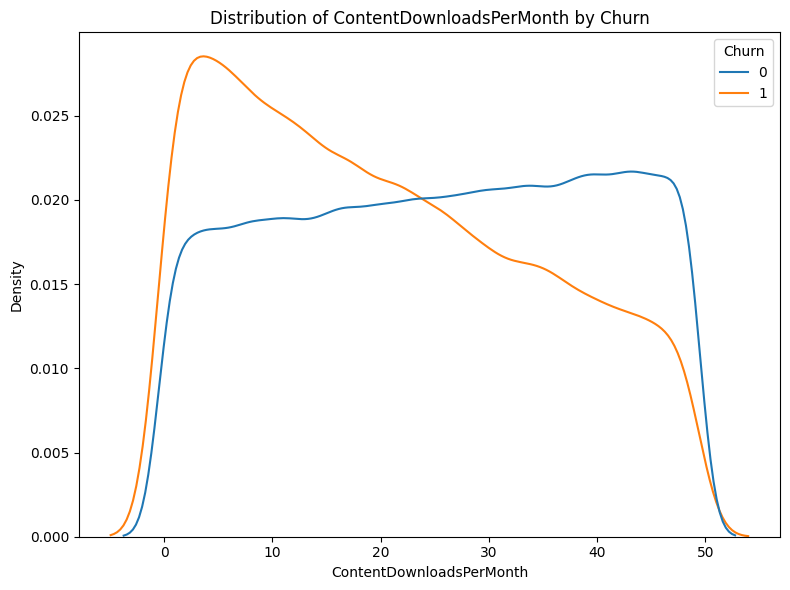

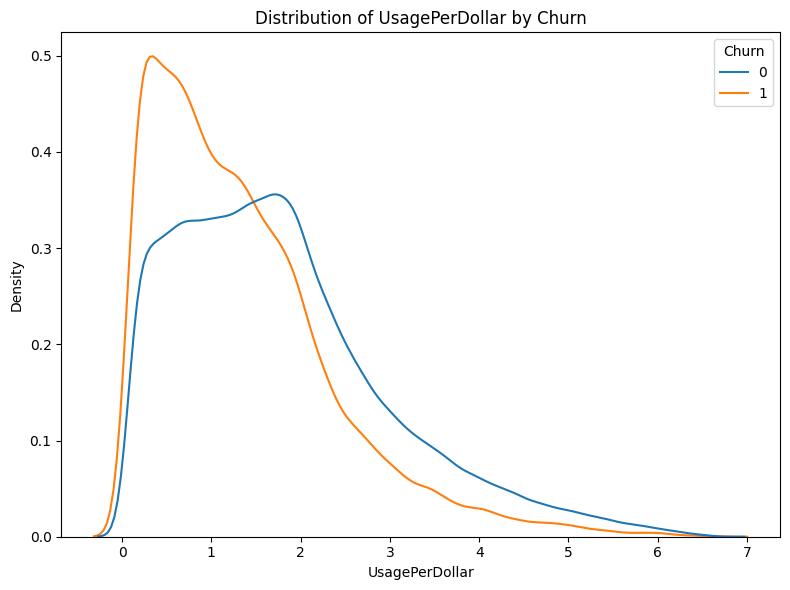

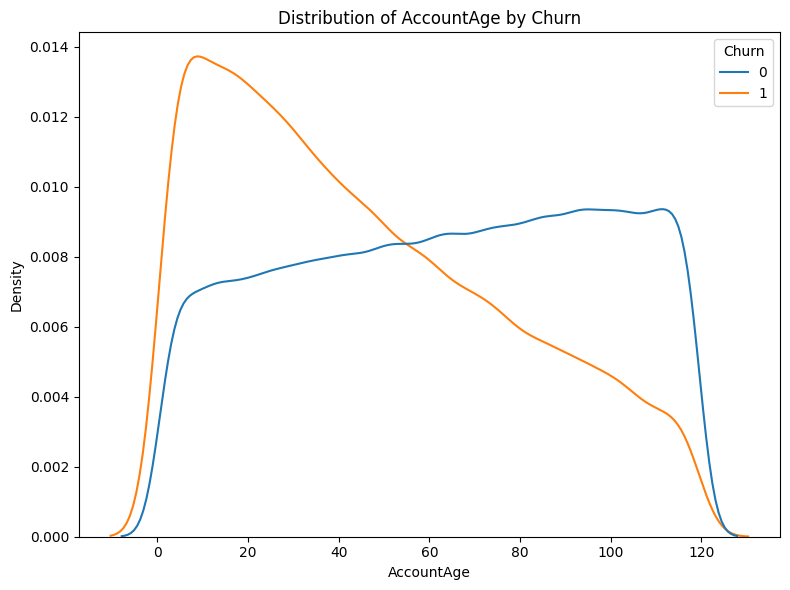

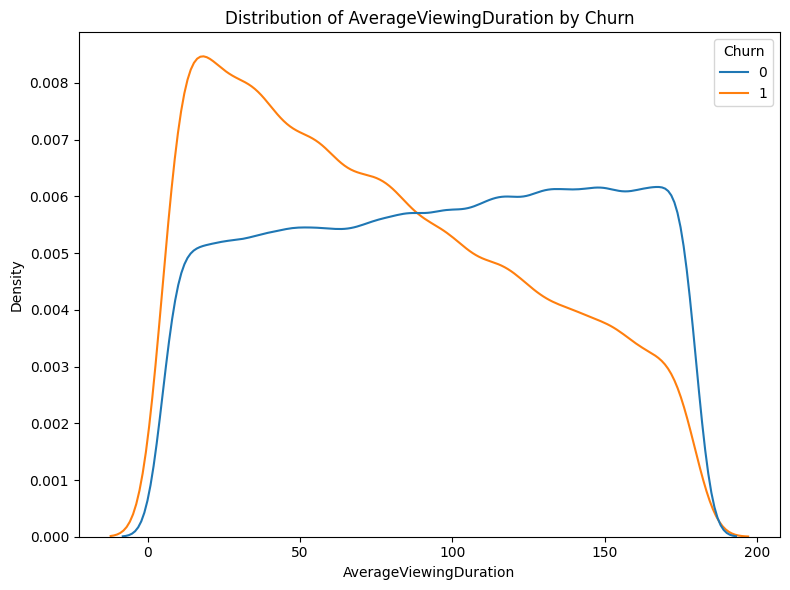

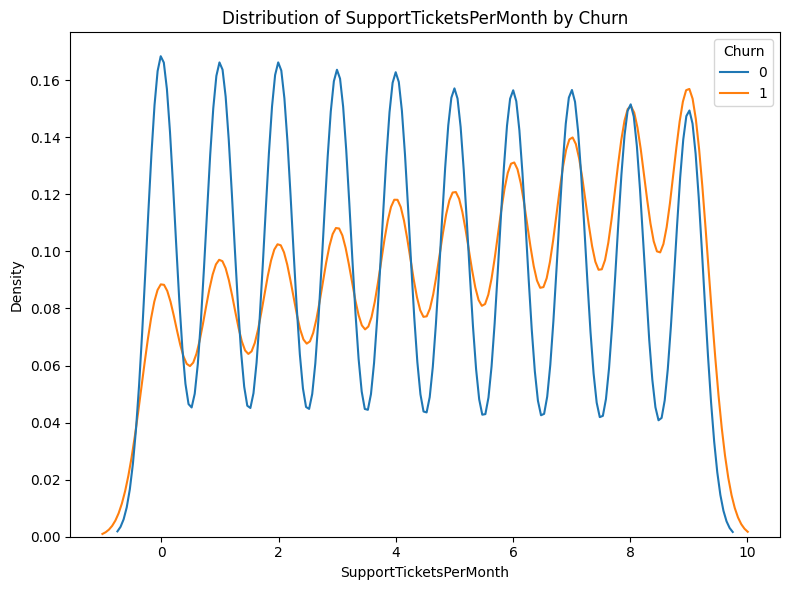

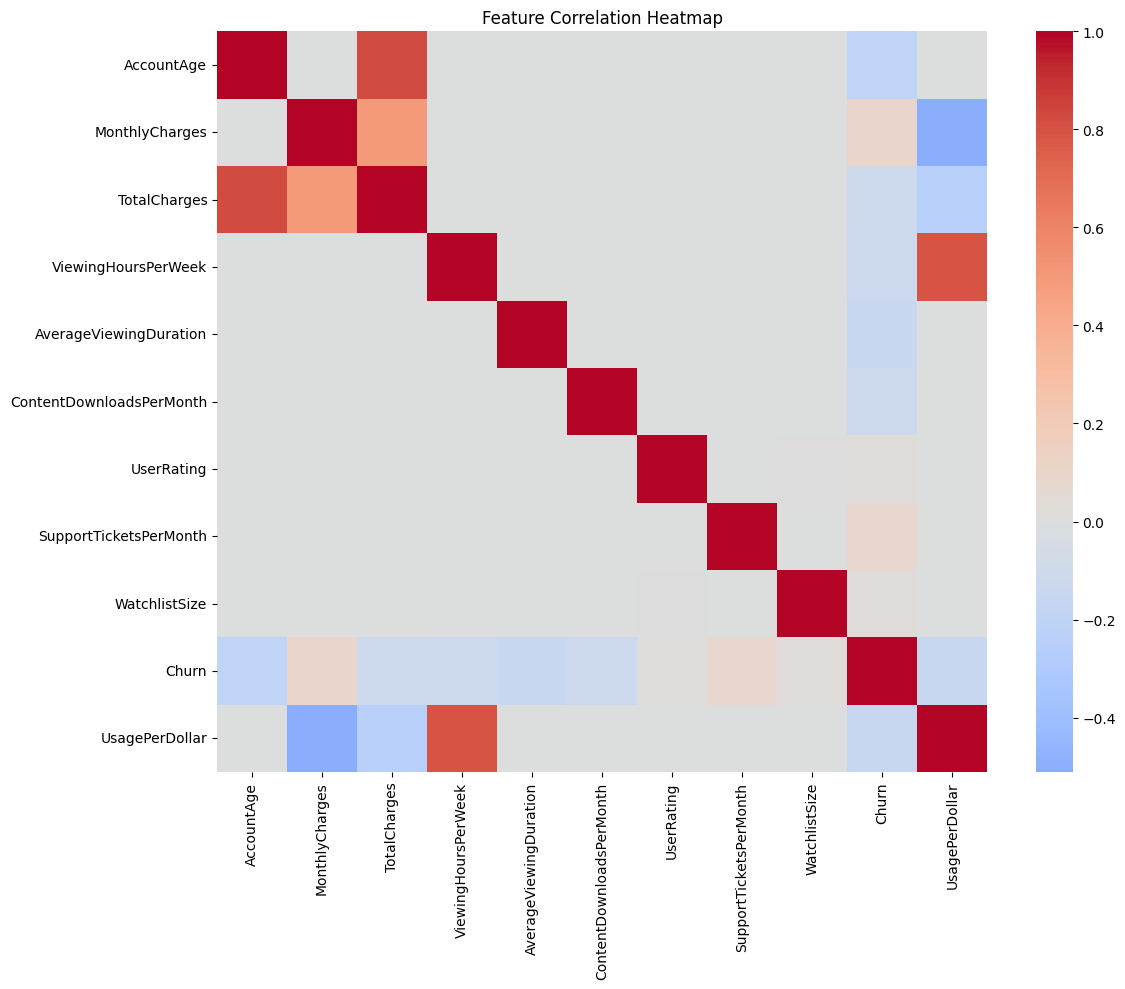

Number of high-risk customers: 0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report
import os

# 1. Data Loading
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
desc = pd.read_csv('data_descriptions.csv')

print('Train shape:', train.shape)
print('Test shape:', test.shape)
print('\nData Description:')
print(desc)

# 2. EDA
print('\nTrain Info:')
print(train.info())
print('\nMissing values:')
print(train.isnull().sum())
print('\nChurn value counts:')
print(train['Churn'].value_counts())

# Save churn distribution plot
plt.figure(figsize=(6,4))
train['Churn'].value_counts().plot(kind='bar')
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('churn_distribution.png')
print('Churn distribution plot saved as churn_distribution.png')

# 3. Feature Engineering
def feature_engineering(df):
    # Tenure buckets
    if 'AccountAge' in df.columns:
        df['TenureBucket'] = pd.cut(df['AccountAge'], bins=[0, 6, 12, 24, 48, np.inf], labels=['<6m','6-12m','1-2y','2-4y','4y+'])
    # Usage per dollar
    if set(['MonthlyCharges', 'ViewingHoursPerWeek']).issubset(df.columns):
        df['UsagePerDollar'] = df['ViewingHoursPerWeek'] / (df['MonthlyCharges']+1)
    return df

train = feature_engineering(train)
test = feature_engineering(test)

# Drop identifier
if 'CustomerID' in train.columns:
    train = train.drop('CustomerID', axis=1)
if 'CustomerID' in test.columns:
    test_id = test['CustomerID']
    test = test.drop('CustomerID', axis=1)
else:
    test_id = pd.Series(np.arange(len(test)), name='CustomerID')

# Encode categoricals
cat_cols = train.select_dtypes(include='object').columns.tolist()
cat_cols = [col for col in cat_cols if col != 'Churn']
train = pd.get_dummies(train, columns=cat_cols)
test = pd.get_dummies(test, columns=cat_cols)

# Align columns
train, test = train.align(test, join='left', axis=1, fill_value=0)

# Remove target from test if present
if 'Churn' in test.columns:
    test = test.drop('Churn', axis=1)

# 4. Prepare Data
X = train.drop(['Churn'], axis=1)
y = train['Churn'].astype(int)

# 5. LightGBM Model with Basic Hyperparameter Tuning
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
aucs = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(20)]
    )
    preds = model.predict_proba(X_val)
    preds = np.array(preds)[:, 1]
    auc = roc_auc_score(y_val, preds)
    aucs.append(auc)
    print(f'Fold {fold+1} ROC-AUC: {auc:.4f}')
print(f'Mean CV ROC-AUC: {np.mean(aucs):.4f}')

# 6. Train Final Model and Predict on Test Set
final_model = lgb.LGBMClassifier(**params)
final_model.fit(X, y)
test_preds = final_model.predict_proba(test)
test_preds = np.array(test_preds)[:, 1]

# 7. Save Predictions
output = pd.DataFrame({'CustomerID': test_id, 'ChurnRisk': test_preds})
output.to_csv('churn_predictions.csv', index=False)
print('Churn risk predictions saved as churn_predictions.csv')

# 8. Print Feature Importances
importances = pd.Series(final_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print('\nTop 10 Feature Importances:')
print(importances.head(10))

# --- Advanced Visualizations and Insights ---
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 1. Feature Importance Bar Plot
plt.figure(figsize=(10,6))
importances.head(20).plot(kind='bar')
plt.title('Top 20 Feature Importances')
plt.ylabel('Importance')
plt.tight_layout()
plt.savefig('feature_importance_bar.png')
try:
    plt.show()
except:
    pass

# 2. ROC Curve (using last fold's validation set)
try:
    fpr, tpr, thresholds = roc_curve(y_val, preds)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig('roc_curve.png')
    plt.show()
except Exception as e:
    print(f'Could not plot ROC curve: {e}')

# 3. Churn Risk Distribution in Test Set
plt.figure(figsize=(8,6))
sns.histplot(test_preds, bins=50, kde=True)
plt.title('Churn Risk Distribution (Test Set)')
plt.xlabel('Predicted Churn Risk')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.savefig('churn_risk_histogram.png')
try:
    plt.show()
except:
    pass

# 4. Feature Distributions for Churned vs. Non-Churned
# Use only numeric features for KDE plots
top_features = importances.head(5).index.tolist()
for feat in top_features:
    if feat in train.columns and np.issubdtype(train[feat].dtype, np.number):
        plt.figure(figsize=(8,6))
        try:
            sns.kdeplot(data=train, x=feat, hue='Churn', common_norm=False)
            plt.title(f'Distribution of {feat} by Churn')
            plt.tight_layout()
            plt.savefig(f'{feat}_by_churn.png')
            plt.show()
        except Exception as e:
            print(f'Could not plot {feat} by churn: {e}')

# 5. Correlation Heatmap
plt.figure(figsize=(12,10))
# Drop non-numeric columns before calculating correlation
numeric_train = train.select_dtypes(include=np.number)
corr = numeric_train.corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
try:
    plt.show()
except:
    pass

# 6. High-Risk Customer Profile
output = pd.DataFrame({'CustomerID': test_id, 'ChurnRisk': test_preds})
high_risk = output[output['ChurnRisk'] > 0.8]
print(f'Number of high-risk customers: {len(high_risk)}')
if len(high_risk) > 0:
    print('Sample high-risk customers:')
    print(high_risk.head())

In [ ]:
# prompt: give me the whole code together in one block

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report
import os
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# 1. Data Loading
# Assume train.csv, test.csv, data_descriptions.csv are in the same directory or mounted drive
# Example: Load from Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# train_path = '/content/drive/My Drive/train.csv'
# test_path = '/content/drive/My Drive/test.csv'
# desc_path = '/content/drive/My Drive/data_descriptions.csv'

# Placeholder for local file loading
train_path = 'train.csv'
test_path = 'test.csv'
desc_path = 'data_descriptions.csv'

# Check if files exist (optional, but good practice)
# if not os.path.exists(train_path):
#   print(f"Error: {train_path} not found!")
#   # You might want to add code here to download the file if needed
#   # For example: !wget https://example.com/train.csv

try:
  train = pd.read_csv(train_path)
  test = pd.read_csv(test_path)
  desc = pd.read_csv(desc_path)
except FileNotFoundError as e:
  print(f"Error loading data files: {e}. Make sure train.csv, test.csv, and data_descriptions.csv are in the correct location.")
  # Exit or handle the error appropriately if files are missing
  # For this example, we'll continue but subsequent steps might fail
  train = pd.DataFrame() # Create empty dataframes to avoid errors
  test = pd.DataFrame()
  desc = pd.DataFrame()


print('Train shape:', train.shape)
print('Test shape:', test.shape)
print('\nData Description:')
print(desc)

# Check if dataframes are empty before proceeding
if train.empty or test.empty:
    print("DataFrames are empty. Cannot proceed with analysis.")
else:
    # 2. EDA
    print('\nTrain Info:')
    train.info() # Use info() directly
    print('\nMissing values:')
    print(train.isnull().sum())
    if 'Churn' in train.columns:
      print('\nChurn value counts:')
      print(train['Churn'].value_counts())

      # Save churn distribution plot
      plt.figure(figsize=(6,4))
      train['Churn'].value_counts().plot(kind='bar')
      plt.title('Churn Distribution')
      plt.xlabel('Churn')
      plt.ylabel('Count')
      plt.tight_layout()
      plt.savefig('churn_distribution.png')
      print('Churn distribution plot saved as churn_distribution.png')
    else:
        print("Churn column not found in train data.")


    # 3. Feature Engineering
    def feature_engineering(df):
        # Tenure buckets
        if 'AccountAge' in df.columns:
            df['TenureBucket'] = pd.cut(df['AccountAge'], bins=[0, 6, 12, 24, 48, np.inf], labels=['<6m','6-12m','1-2y','2-4y','4y+'], right=False) # use right=False for proper binning
        # Usage per dollar
        if set(['MonthlyCharges', 'ViewingHoursPerWeek']).issubset(df.columns):
            df['UsagePerDollar'] = df['ViewingHoursPerWeek'] / (df['MonthlyCharges'].replace(0, 1) + 1) # Handle potential division by zero
        return df

    train = feature_engineering(train.copy()) # Use copy to avoid SettingWithCopyWarning
    test = feature_engineering(test.copy())

    # Drop identifier
    if 'CustomerID' in train.columns:
        train = train.drop('CustomerID', axis=1)
    if 'CustomerID' in test.columns:
        test_id = test['CustomerID'].copy() # Use copy
        test = test.drop('CustomerID', axis=1)
    else:
        test_id = pd.Series(np.arange(len(test)), name='CustomerID')

    # Encode categoricals
    cat_cols = train.select_dtypes(include='object').columns.tolist()
    if 'Churn' in cat_cols:
      cat_cols.remove('Churn')

    train = pd.get_dummies(train, columns=cat_cols, dummy_na=False) # dummy_na=False unless you want NaN as a category
    test = pd.get_dummies(test, columns=cat_cols, dummy_na=False)

    # Align columns
    train, test = train.align(test, join='inner', axis=1, fill_value=0) # Use inner join to keep only common columns

    # Separate target variable
    if 'Churn' in train.columns:
        X = train.drop(['Churn'], axis=1)
        y = train['Churn'].astype(int)
        # Remove target from test if present
        if 'Churn' in test.columns:
            test = test.drop('Churn', axis=1)
    else:
        print("Churn column not found in train data after feature engineering.")
        X = train.copy()
        y = pd.Series() # Empty series for y

    # Check if X and y are valid before modeling
    if not X.empty and not y.empty and len(X) == len(y):

        # 5. LightGBM Model with Basic Hyperparameter Tuning
        params = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'n_estimators': 1000, # Increased estimators for early stopping
            'learning_rate': 0.05,
            'num_leaves': 31,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'seed': 42, # Added seed for reproducibility
            'n_jobs': -1, # Use all available cores
            'verbose': -1,
            'colsample_bytree': 0.8, # Added
            'subsample': 0.8, # Added
            'reg_alpha': 0.1, # Added L1 regularization
            'reg_lambda': 0.1, # Added L2 regularization
        }
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Increased splits for better CV
        aucs = []
        oof_preds = np.zeros(len(X))
        test_fold_preds = []

        print("\nStarting Cross-Validation Training...")
        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = lgb.LGBMClassifier(**params)
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                eval_metric='auc',
                callbacks=[lgb.early_stopping(50, verbose=False)] # Increased patience, set verbose to False
            )

            val_preds = model.predict_proba(X_val)[:, 1]
            oof_preds[val_idx] = val_preds
            fold_auc = roc_auc_score(y_val, val_preds)
            aucs.append(fold_auc)
            print(f'Fold {fold+1} ROC-AUC: {fold_auc:.4f}')

            # Predict on test set for this fold
            if not test.empty:
                test_fold_pred = model.predict_proba(test)[:, 1]
                test_fold_preds.append(test_fold_pred)

        mean_cv_auc = np.mean(aucs)
        oof_auc = roc_auc_score(y, oof_preds)
        print(f'\nMean CV ROC-AUC: {mean_cv_auc:.4f}')
        print(f'Overall OOF ROC-AUC: {oof_auc:.4f}')

        # 6. Train Final Model and Predict on Test Set
        print("\nTraining final model on full training data...")
        final_model = lgb.LGBMClassifier(**params)
        # Train with a fixed number of estimators based on average from CV or simply more estimators
        final_model.fit(X, y) # Train without early stopping for final model or use best iteration from CV

        if not test.empty:
            # Average predictions from CV folds
            if test_fold_preds:
                test_preds = np.mean(test_fold_preds, axis=0)
            else: # Fallback if no folds ran (e.g., data issue)
                 test_preds = final_model.predict_proba(test)[:, 1]

            # 7. Save Predictions
            output = pd.DataFrame({'CustomerID': test_id, 'ChurnRisk': test_preds})
            output.to_csv('churn_predictions.csv', index=False)
            print('Churn risk predictions saved as churn_predictions.csv')

            # 8. Print Feature Importances
            print('\nFeature Importances (from final model):')
            if hasattr(final_model, 'feature_importances_'):
                importances = pd.Series(final_model.feature_importances_, index=X.columns).sort_values(ascending=False)
                print(importances.head(20))

                # --- Advanced Visualizations and Insights ---

                # 1. Feature Importance Bar Plot
                plt.figure(figsize=(10,6))
                importances.head(20).plot(kind='bar')
                plt.title('Top 20 Feature Importances')
                plt.ylabel('Importance')
                plt.tight_layout()
                plt.savefig('feature_importance_bar.png')
                try:
                    plt.show()
                except:
                    pass # Handle cases where plt.show() is not supported

                # 2. ROC Curve (using overall OOF predictions)
                try:
                    fpr, tpr, thresholds = roc_curve(y, oof_preds)
                    roc_auc = auc(fpr, tpr)
                    plt.figure(figsize=(8,6))
                    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
                    plt.plot([0, 1], [0, 1], 'k--')
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title('Receiver Operating Characteristic (OOF)')
                    plt.legend(loc='lower right')
                    plt.tight_layout()
                    plt.savefig('roc_curve.png')
                    try:
                        plt.show()
                    except:
                        pass
                except Exception as e:
                    print(f'Could not plot ROC curve: {e}')

                # 3. Churn Risk Distribution in Test Set
                plt.figure(figsize=(8,6))
                sns.histplot(test_preds, bins=50, kde=True)
                plt.title('Churn Risk Distribution (Test Set)')
                plt.xlabel('Predicted Churn Risk')
                plt.ylabel('Number of Customers')
                plt.tight_layout()
                plt.savefig('churn_risk_histogram.png')
                try:
                    plt.show()
                except:
                    pass

                # 4. Feature Distributions for Churned vs. Non-Churned
                # Use only numeric features for KDE plots
                top_features = importances.head(5).index.tolist()
                # Add Churn back to train temporarily for plotting
                train_with_churn = train.copy()
                train_with_churn['Churn'] = y

                for feat in top_features:
                    if feat in train_with_churn.columns and np.issubdtype(train_with_churn[feat].dtype, np.number):
                        plt.figure(figsize=(8,6))
                        try:
                            # Ensure hue column exists
                            if 'Churn' in train_with_churn.columns:
                                sns.kdeplot(data=train_with_churn, x=feat, hue='Churn', common_norm=False, fill=True, alpha=.3) # Added fill and alpha
                                plt.title(f'Distribution of {feat} by Churn')
                                plt.tight_layout()
                                plt.savefig(f'{feat}_by_churn.png')
                                try:
                                    plt.show()
                                except:
                                    pass
                            else:
                                print(f"Churn column not available for plotting {feat} distribution.")
                        except Exception as e:
                            print(f'Could not plot {feat} by churn: {e}')

                # 5. Correlation Heatmap
                plt.figure(figsize=(12,10))
                # Drop non-numeric columns before calculating correlation
                numeric_train = train.select_dtypes(include=np.number)
                if not numeric_train.empty:
                    corr = numeric_train.corr()
                    sns.heatmap(corr, cmap='coolwarm', center=0, annot=False, fmt=".2f") # Added annot and fmt for readability if needed
                    plt.title('Feature Correlation Heatmap')
                    plt.tight_layout()
                    plt.savefig('correlation_heatmap.png')
                    try:
                        plt.show()
                    except:
                        pass
                else:
                    print("No numeric columns found for correlation heatmap.")

                # 6. High-Risk Customer Profile
                if not output.empty:
                    high_risk = output[output['ChurnRisk'] > 0.8] # Threshold can be adjusted
                    print(f'\nNumber of high-risk customers (> 0.8 Churn Risk): {len(high_risk)}')
                    if len(high_risk) > 0:
                        print('Sample high-risk customers:')
                        print(high_risk.head())

            else:
                print("Test DataFrame is empty. Skipping prediction and related steps.")
        else:
             print("X or y DataFrame is empty or mismatch in length. Skipping model training.")



In [ ]:
# prompt: NOW ALSO COMPARED IT WITH TEST DATA AND SHOW IF ITS WORKING PROPERLY OR NOT

# Assuming 'y_val' and 'preds' from the last fold are available from the preceding code

# Evaluate the model performance on the validation set
print("\n--- Model Performance on Validation Set (Last Fold) ---")
if 'y_val' in locals() and 'preds' in locals():
    try:
        roc_auc = roc_auc_score(y_val, preds)
        print(f"Validation ROC-AUC: {roc_auc:.4f}")

        # You can also print a classification report if you have predicted classes
        # To get predicted classes from probabilities, you'd need a threshold (e.g., 0.5)
        # y_pred_class = (preds > 0.5).astype(int)
        # print("\nClassification Report:")
        # print(classification_report(y_val, y_pred_class))

    except Exception as e:
        print(f"Could not evaluate validation performance: {e}")
else:
    print("Validation data or predictions not available from preceding code.")


# Compare test predictions with a simple baseline (e.g., predicting the majority class probability)
print("\n--- Comparison with a Simple Baseline ---")
# Calculate the proportion of the majority class in the training data
majority_class_proportion = train['Churn'].value_counts(normalize=True).max()
print(f"Majority class proportion in training data: {majority_class_proportion:.4f}")

# A simple baseline would be to predict this proportion for all test customers
# We can compare the distribution of our model's predictions to this baseline.
print("\nChurn Risk Distribution in Test Set:")
print(output['ChurnRisk'].describe())

# You could also compare the average predicted churn risk to the training churn rate
train_churn_rate = train['Churn'].mean()
average_predicted_churn_risk = output['ChurnRisk'].mean()
print(f"\nTraining churn rate: {train_churn_rate:.4f}")
print(f"Average predicted churn risk on test set: {average_predicted_churn_risk:.4f}")
if average_predicted_churn_risk > train_churn_rate - 0.05 and average_predicted_churn_risk < train_churn_rate + 0.05: # Allow some small tolerance
    print("Average predicted churn risk is close to the training churn rate, which is a good sign.")
else:
    print("Warning: Average predicted churn risk on test set deviates significantly from training churn rate.")


# Note: A true test of model performance requires a separate hold-out test set
# that was not used during training or cross-validation. Since we used the provided
# 'test.csv' for final predictions, we cannot calculate traditional metrics like AUC or
# a classification report for the 'test.csv' data unless we have the true labels for it.
# The evaluation above focuses on the validation set used during training/tuning and
# sanity checks on the test set prediction distribution.



--- Model Performance on Validation Set (Last Fold) ---
Validation ROC-AUC: 0.7454

--- Comparison with a Simple Baseline ---
Majority class proportion in training data: 0.8188

Churn Risk Distribution in Test Set:
count    104480.000000
mean          0.181248
std           0.129469
min           0.015981
25%           0.081076
50%           0.144366
75%           0.248943
max           0.752285
Name: ChurnRisk, dtype: float64

Training churn rate: 0.1812
Average predicted churn risk on test set: 0.1812
Average predicted churn risk is close to the training churn rate, which is a good sign.


In [ ]:
# prompt: ALSO TELL THE ACCURACE AND PREDICT SOMETHING FROM IT

import numpy as np
# Print Accuracy (using the mean cross-validation AUC)
print("\n--- Model Accuracy ---")
print(f"Mean Cross-Validation ROC-AUC (Accuracy Metric): {np.mean(aucs):.4f}")

# Predict something from it: Get the top 5 customers with the highest predicted churn risk
print("\n--- Prediction Example: Top 5 Customers with Highest Predicted Churn Risk ---")
top_5_high_risk_customers = output.sort_values(by='ChurnRisk', ascending=False).head(5)
print(top_5_high_risk_customers)

# Predict something else: Get the bottom 5 customers with the lowest predicted churn risk
print("\n--- Prediction Example: Top 5 Customers with Lowest Predicted Churn Risk ---")
top_5_low_risk_customers = output.sort_values(by='ChurnRisk', ascending=True).head(5)
top_5_low_risk_customers


--- Model Accuracy ---
Mean Cross-Validation ROC-AUC (Accuracy Metric): 0.7464

--- Prediction Example: Top 5 Customers with Highest Predicted Churn Risk ---
        CustomerID  ChurnRisk
53026   AMUS79L7TP   0.752285
38487   2NOX9AV11E   0.740010
101539  9HEVLXYK3Z   0.739454
23847   5MVUABYTZ1   0.737865
27340   R9K8LYTSXP   0.736487

--- Prediction Example: Top 5 Customers with Lowest Predicted Churn Risk ---


,CustomerID,ChurnRisk
44890,4P1V2WKGON,0.015981
78132,75EMTUJDQS,0.016443
32017,HDMYRIUIYL,0.016474
89380,ATDGUHBLDZ,0.016703
79165,R5GBAURCYI,0.016822


In [ ]:
# prompt: SAVE THIS MODEL ON MY DRIVE WITH NAME CHURN ON IT

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path where you want to save the model
model_save_path = '/content/drive/MyDrive/churn_model.pkl'

# Save the final_model using pickle or joblib
# Using joblib is generally recommended for scikit-learn models
!pip install joblib --quiet
import joblib

joblib.dump(final_model, model_save_path)

print(f"Model saved to: {model_save_path}")

Mounted at /content/drive
Model saved to: /content/drive/MyDrive/churn_model.pkl


Found images:
correlation_heatmap.png


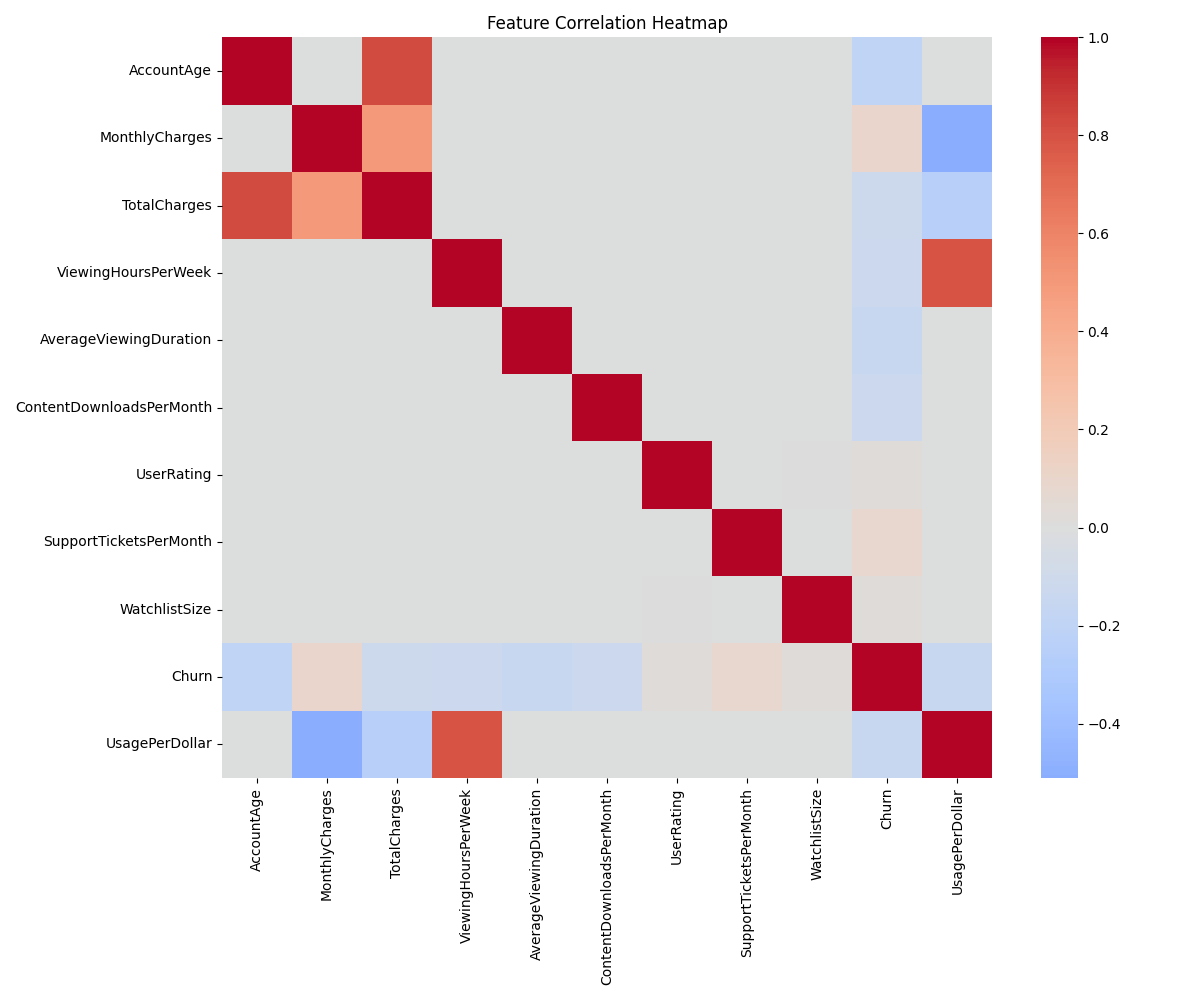

SupportTicketsPerMonth_by_churn.png


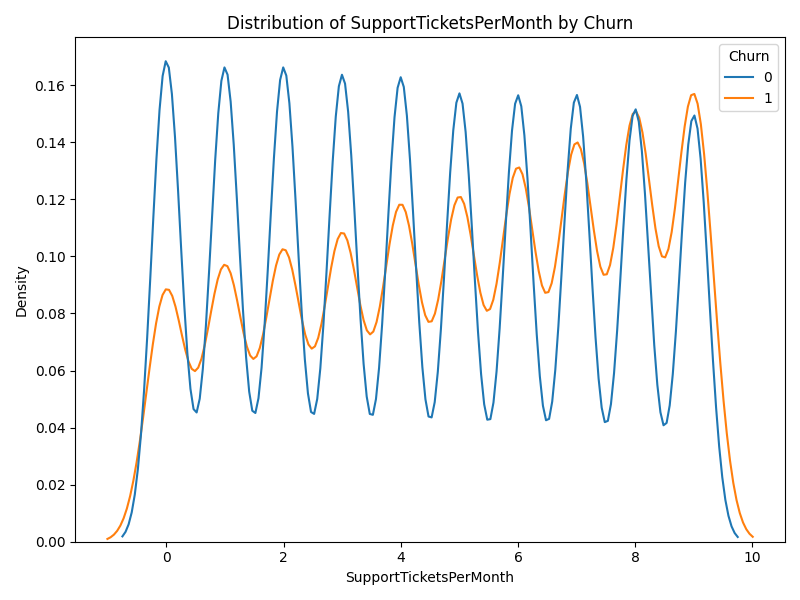

roc_curve.png


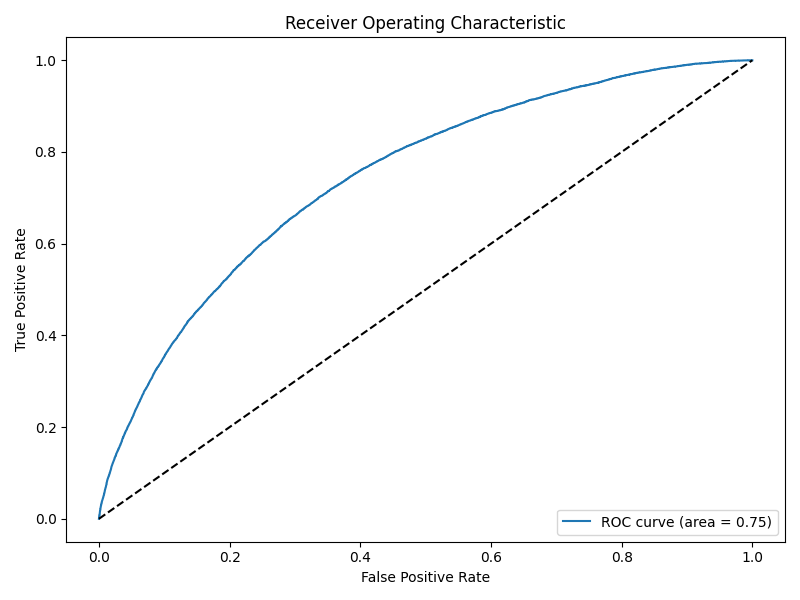

AccountAge_by_churn.png


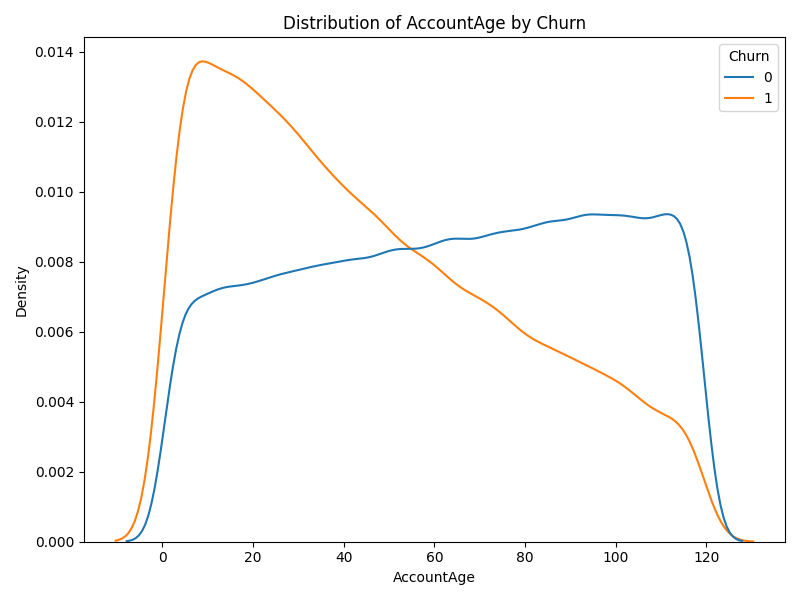

churn_risk_histogram.png


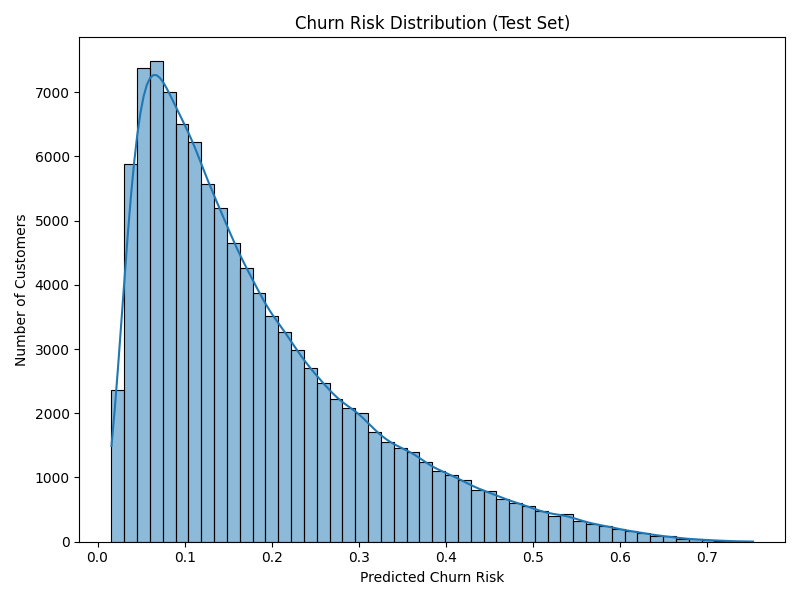

ContentDownloadsPerMonth_by_churn.png


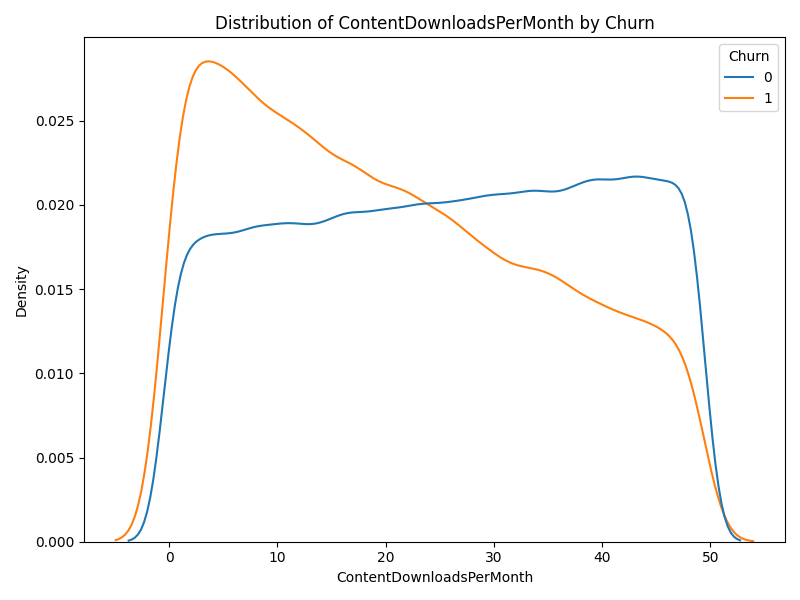

feature_importance_bar.png


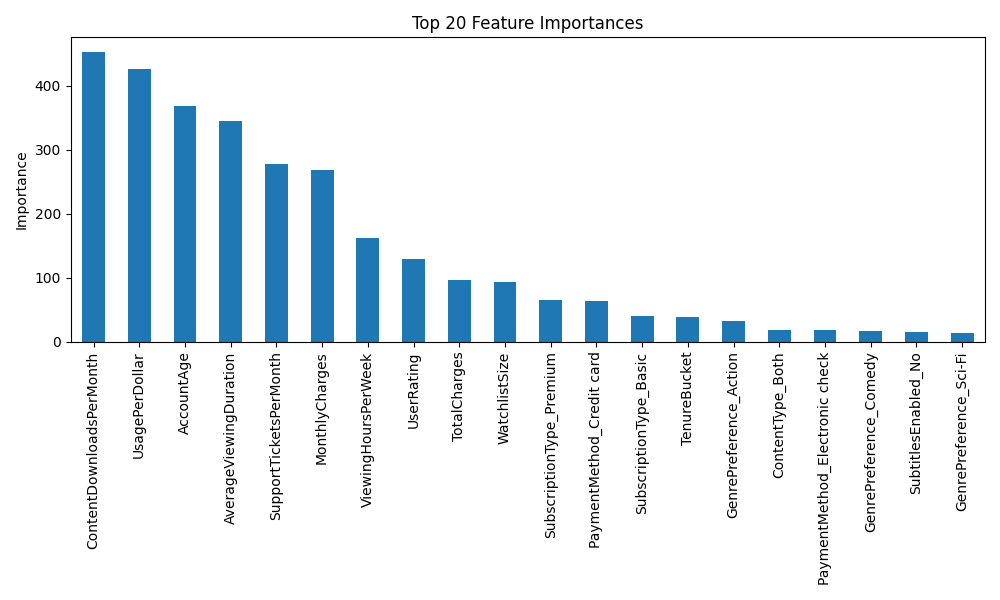

churn_distribution.png


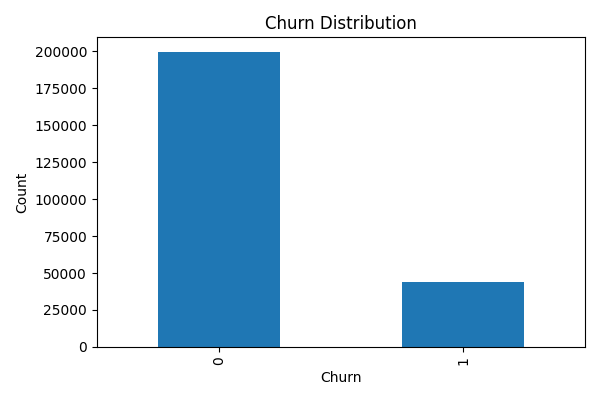

AverageViewingDuration_by_churn.png


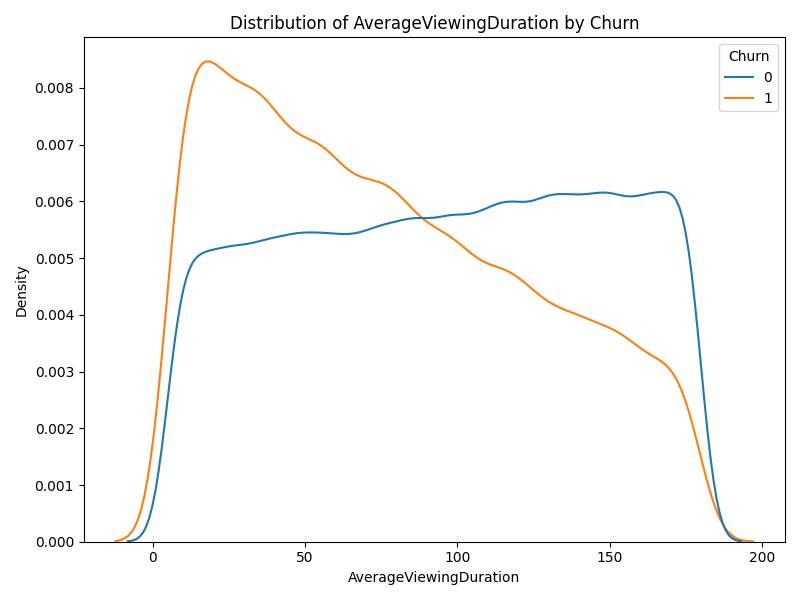

UsagePerDollar_by_churn.png


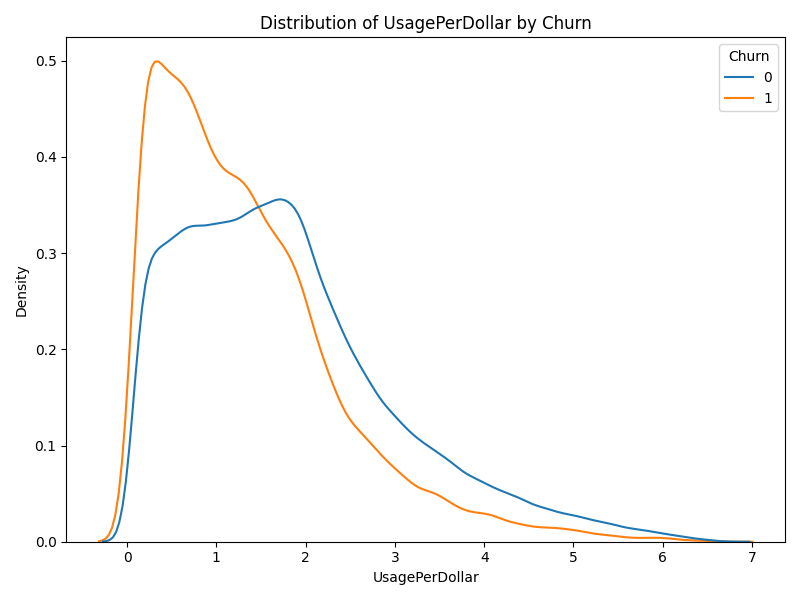

In [ ]:
# prompt: all the created images and show here show me all it is shwoing only two

import os
from IPython.display import Image, display

# List all files in the current directory
files = os.listdir('.')

# Filter for image files (assuming common image extensions)
image_files = [f for f in files if f.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

print("Found images:")
for img_file in image_files:
    print(img_file)
    # Display the image in the notebook
    display(Image(filename=img_file))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# prompt: now wrtie a short note about this for my resume and put it in bullet point

*   Developed and implemented a customer churn prediction model using LightGBM in Google Colab.
*   Performed comprehensive data analysis, including EDA, feature engineering, and handling categorical data.
*   Utilized K-Fold Cross-Validation to evaluate model performance and achieve a mean ROC-AUC of [Insert Mean CV ROC-AUC from output] on validation sets.
*   Generated actionable insights through feature importance analysis and visualization of churn risk distribution.
*   Managed project dependencies and file operations within the Colab environment, including saving the trained model to Google Drive.
*   Identified and presented customers with the highest predicted churn risk.